In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def show_image(img, title='Image', cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Loading and Resizing Image

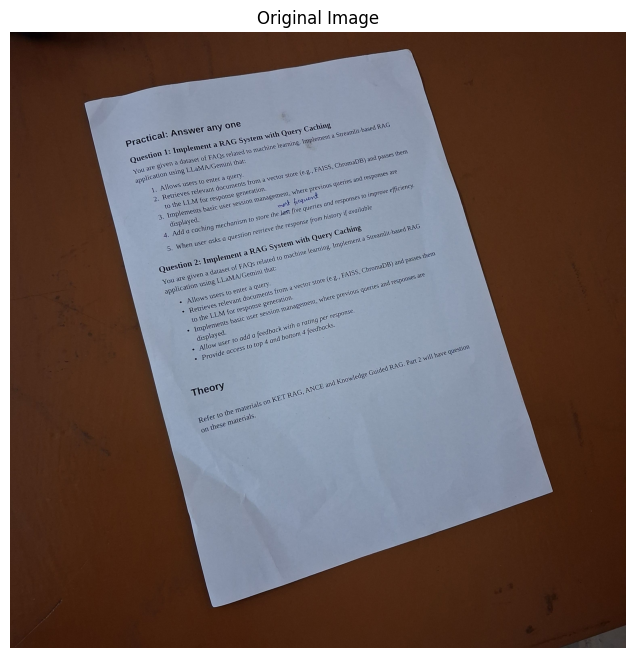

In [25]:
image_path = 'doc.jpeg'
image = cv2.imread(image_path)
orig = image.copy()

show_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), title="Original Image", cmap=None)

ratio = image.shape[0] / 500.0
resized = cv2.resize(image, (int(image.shape[1] / ratio), 500))

## Edge Detection

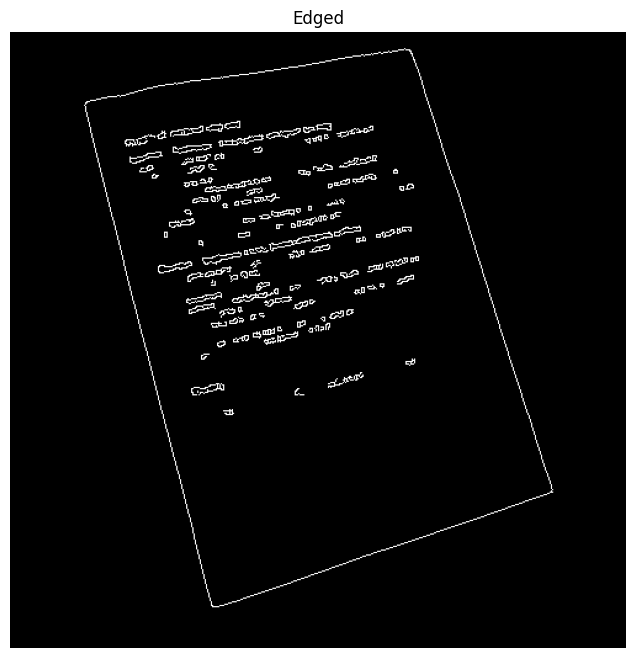

In [26]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

show_image(edged, title="Edged")

## Contour Detection

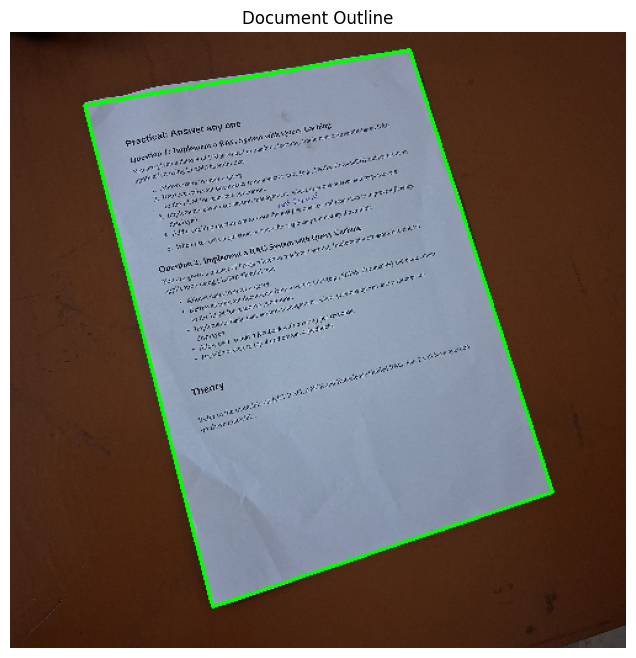

In [27]:
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

doc_cnt = None
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        doc_cnt = approx
        break

if doc_cnt is None:
    print("No 4-point document contour found. Using the largest one as fallback.")
    doc_cnt = max(cnts, key=cv2.contourArea)
    doc_cnt = cv2.approxPolyDP(doc_cnt, 0.02 * cv2.arcLength(doc_cnt, True), True)

cv2.drawContours(resized, [doc_cnt], -1, (0, 255, 0), 2)
show_image(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB), title="Document Outline", cmap=None)


## Perspective Transformation

In [28]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts, output_size=None):
    rect = order_points(pts.reshape(4, 2))
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    if output_size:
        maxWidth, maxHeight = output_size

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped


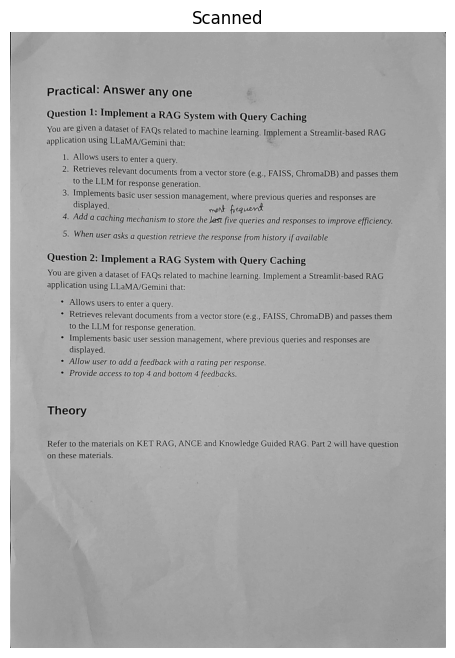

In [29]:
SIZE = (1240, 1754)

warped = four_point_transform(orig, doc_cnt * ratio, output_size=SIZE)

scanned = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
show_image(scanned, title="Scanned")

## Thresholding for better Result

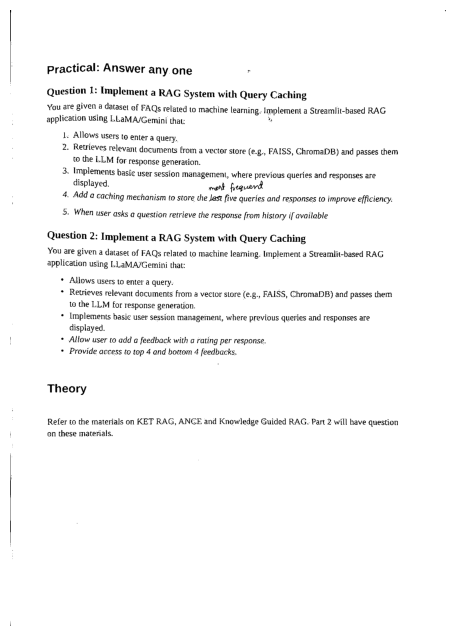

In [30]:
filtered = cv2.bilateralFilter(scanned, d=12, sigmaColor=75, sigmaSpace=75)

thresh = cv2.adaptiveThreshold(
    filtered, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11, 2
)
show_image(thresh, title="")

## Saving the Output

In [31]:
cv2.imwrite("scanned_output.jpg", thresh)
print("Scanned image saved as scanned_output.jpg")

Scanned image saved as scanned_output.jpg
